In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [24]:
plt.style.use('ggplot')
sns.set_style('whitegrid')

In [27]:
df = pd.read_csv('uber.csv')

In [29]:
print("\n--- Starting Data Preprocessing ---")


--- Starting Data Preprocessing ---


In [31]:
# Drop unnecessary column
if 'key' in df.columns:
    df = df.drop('key', axis=1)

In [33]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df.dropna(subset=['pickup_datetime'], inplace=True)

In [34]:
# Handle missing values (median imputation)
print(f"Missing values before cleaning:\n{df.isnull().sum()}")
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

Missing values before cleaning:
Unnamed: 0           0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [37]:
# Convert pickup_datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df.dropna(subset=['pickup_datetime'], inplace=True)

In [39]:

print(f"\nMissing values after cleaning:\n{df.isnull().sum()}")


Missing values after cleaning:
Unnamed: 0           0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [41]:
# Extract datetime features
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

In [43]:
# --- Vectorized Haversine distance ---
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [45]:
df['distance_km'] = haversine_vectorized(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)

In [47]:
# Drop raw latitude/longitude and datetime
df = df.drop([
    'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude'
], axis=1)

In [49]:
print("\nData preprocessing complete.")


Data preprocessing complete.


In [85]:
# --- Boxplots BEFORE removing outliers ---
print("\n--- Visualizing distributions BEFORE removing outliers ---")
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); sns.boxplot(x=df['fare_amount']); plt.title('Fare Amount (Before)')
plt.subplot(1,3,2); sns.boxplot(x=df['distance_km']); plt.title('Distance (Before)')
plt.subplot(1,3,3); sns.boxplot(x=df['passenger_count']); plt.title('Passenger Count (Before)')
plt.tight_layout(); plt.show()


--- Visualizing distributions BEFORE removing outliers ---


In [53]:
# --- IQR outlier removal ---
print("\n--- Removing Outliers using IQR ---")
def remove_outliers_iqr(df, column, min_value=None):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    if min_value is not None:
        lower = max(lower, min_value)
    print(f"{column}: removing outside [{lower:.2f}, {upper:.2f}]")
    return df[(df[column] >= lower) & (df[column] <= upper)]

df = remove_outliers_iqr(df, 'fare_amount', min_value=0)
df = remove_outliers_iqr(df, 'distance_km', min_value=0)
df = remove_outliers_iqr(df, 'passenger_count', min_value=1)


--- Removing Outliers using IQR ---
fare_amount: removing outside [0.00, 22.25]
distance_km: removing outside [0.00, 6.46]
passenger_count: removing outside [1.00, 3.50]


In [55]:
# Ensure passenger_count is integer
df['passenger_count'] = df['passenger_count'].astype(int)

In [57]:
print(f"Dataset shape after outlier removal: {df.shape}")

Dataset shape after outlier removal: (154228, 9)


In [59]:
# --- Boxplots AFTER removing outliers ---
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); sns.boxplot(x=df['fare_amount']); plt.title('Fare Amount (After)')
plt.subplot(1,3,2); sns.boxplot(x=df['distance_km']); plt.title('Distance (After)')
plt.subplot(1,3,3); sns.boxplot(x=df['passenger_count']); plt.title('Passenger Count (After)')
plt.tight_layout(); plt.show()


--- Checking Correlation ---


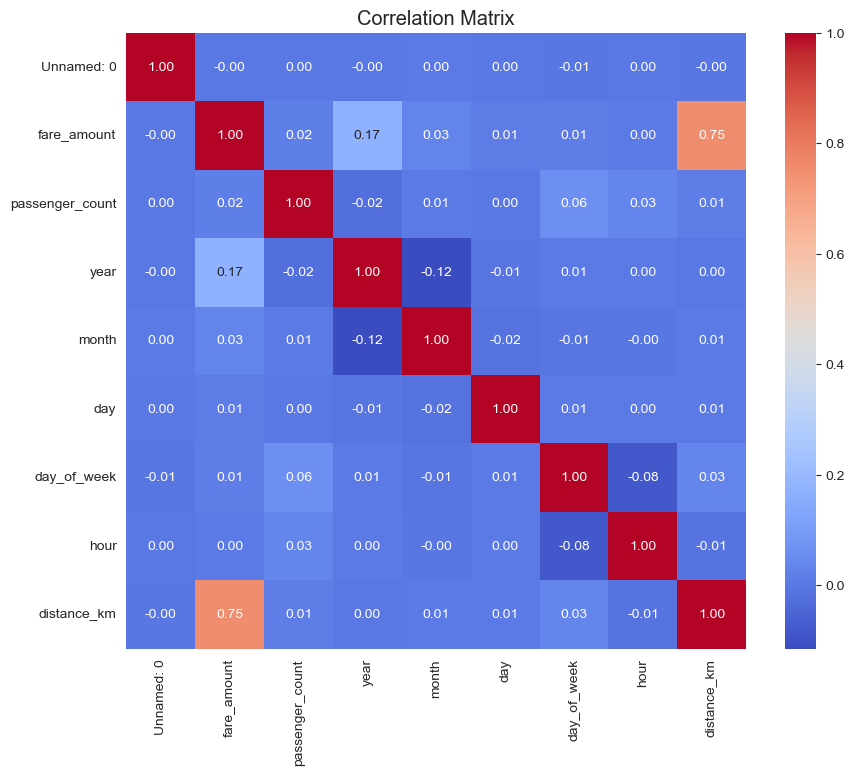

In [61]:
# --- Correlation matrix ---
print("\n--- Checking Correlation ---")
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [63]:
# --- Regression Models ---
features = ['passenger_count','distance_km','year','month','day','day_of_week','hour']
target = 'fare_amount'

In [65]:
X = df[features]
y = df[target]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 123382, Testing samples: 30846


In [69]:
linear_model = LinearRegression().fit(X_train, y_train)
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train)

In [70]:
print("Model trained")

Model trained


In [71]:
# --- Model evaluation ---
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"\n{name}: R2={r2:.4f}, MAE={mae:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}")
    return y_pred, r2, mae, rmse

y_pred_lr, lr_r2, lr_mae, lr_rmse = evaluate_model(linear_model, X_test, y_test, "Linear Regression")
y_pred_rf, rf_r2, rf_mae, rf_rmse = evaluate_model(random_forest_model, X_test, y_test, "Random Forest")

print("\n--- Model Comparison ---")
if rf_rmse < lr_rmse:
    print("Random Forest performs better (lower RMSE).")
else:
    print("Linear Regression performs better (lower RMSE).")


Linear Regression: R2=0.6049, MAE=1.6460, MSE=5.4745, RMSE=2.3398

Random Forest: R2=0.6600, MAE=1.5311, MSE=4.7117, RMSE=2.1707

--- Model Comparison ---
Random Forest performs better (lower RMSE).


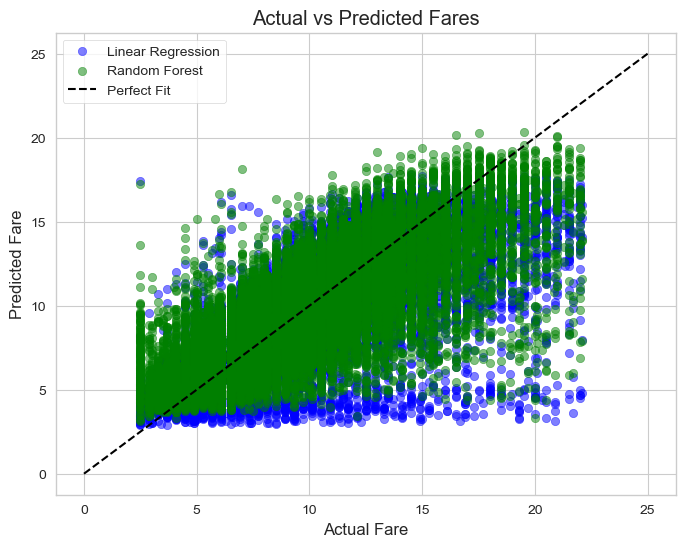

In [72]:
# --- Scatter plot: Actual vs Predicted ---
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label="Linear Regression", color='blue')
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest", color='green')
plt.plot([0,25],[0,25],'k--', label="Perfect Fit")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.legend()
plt.title("Actual vs Predicted Fares")
plt.show()